In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score

# Step 1: Load the dataset
file_path = "/content/merged_restaurants_census.csv"
df = pd.read_csv(file_path)

# Reduce the dataset size by taking a random sample (e.g., 30,000 rows)
df_sampled = df.sample(n=30000, random_state=42)

# Select only 3 numerical features for clustering
selected_features = ["Rating", "Median_Income", "Population"]
df_selected = df_sampled[selected_features]
print("Labeled and Mixed Dataset: \n",df_selected.head(),"\n")

df_selected.to_csv("clustering_data.csv", index=False)

print("File saved successfully as 'clustering_data.csv'")

Labeled and Mixed Dataset: 
        Rating  Median_Income  Population
5658      4.6        59883.0     35392.0
3615      4.7        57684.0     51840.0
44218     4.2        62222.0     28727.0
35979     4.6       138279.0     23475.0
73089     3.8        35279.0     38726.0 

File saved successfully as 'clustering_data.csv'


In [43]:
# Normalize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)
df_scaled = pd.DataFrame(df_scaled, columns=selected_features)

# Display the preprocessed data
print("Scaled Dataset:")
print(df_scaled.head())

Scaled Dataset:
     Rating  Median_Income  Population
0  0.800786      -0.526336    0.261771
1  1.046253      -0.597549    1.245448
2 -0.181081      -0.450590   -0.136831
3  0.800786       2.012458   -0.450928
4 -1.162948      -1.323118    0.461162


In [44]:
# Perform PCA (Optional - Reduce to 3D for visualization)
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)

# Calculate the variance retained after PCA
variance_retained = np.sum(pca.explained_variance_ratio_) * 100

# Display the preprocessed data
print("PCA reduced, normalized, quant, and unlabeled dataset: \n",df_scaled.head(),"\n")

# Print variance retained after PCA
print(f"Variance Retained After PCA: ",variance_retained,"%")

PCA reduced, normalized, quant, and unlabeled dataset: 
      Rating  Median_Income  Population
0  0.800786      -0.526336    0.261771
1  1.046253      -0.597549    1.245448
2 -0.181081      -0.450590   -0.136831
3  0.800786       2.012458   -0.450928
4 -1.162948      -1.323118    0.461162 

Variance Retained After PCA:  100.0 %


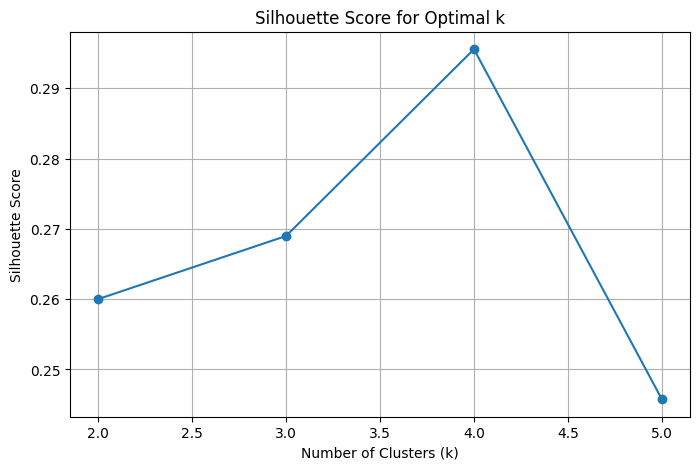

Top three selected k values for clustering: [4, 3, 2]


In [45]:
# Step 2: Determine the Best `k` using Silhouette Score and Plot the Graph
sil_scores = []
K_range = range(2, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    sil_scores.append(score)

# Select the top three values of k with the highest silhouette scores
top_k_values = sorted(zip(K_range, sil_scores), key=lambda x: x[1], reverse=True)[:3]
top_k_values = [k for k, _ in top_k_values]  # Extract k values

# Plot silhouette scores for different k values
plt.figure(figsize=(8, 5))
plt.plot(K_range, sil_scores, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.grid(True)
plt.show()

# Display the chosen k values
print(f"Top three selected k values for clustering: {top_k_values}")



In [46]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
#3D scatter plot
# Step 3: Apply K-Means Clustering for 3 Best `k` Values and Create Interactive 3D Plots

for k in top_k_values:
    # Apply K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_scaled[f"Cluster_k{k}"] = kmeans.fit_predict(df_scaled[selected_features])

    # Create a DataFrame for plotting
    df_plot = df_scaled.copy()
    df_plot["Cluster"] = df_plot[f"Cluster_k{k}"]

    # Get centroids
    centroids = kmeans.cluster_centers_

    # Create interactive 3D scatter plot
    fig = px.scatter_3d(df_plot, x="Rating", y="Median_Income", z="Population",
                        color="Cluster", opacity=0.7, title=f"K-Means Clustering (k={k})",
                        hover_data={"Rating": True, "Median_Income": True, "Population": True})

    # Add centroids as red 'X' markers
    fig.add_trace(go.Scatter3d(x=centroids[:, 0], y=centroids[:, 1], z=centroids[:, 2],
                               mode='markers', marker=dict(size=8, color='red', symbol='x'),
                               name="Centroids"))

    # Show the plot
    fig.show()

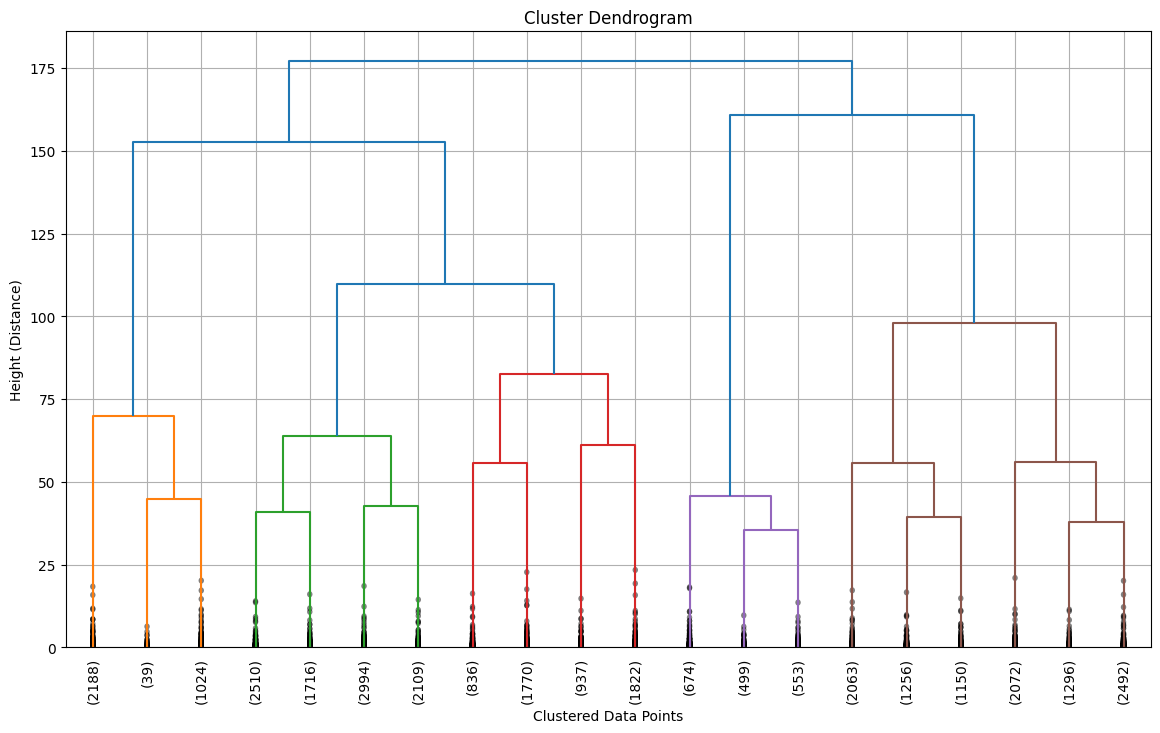

In [47]:
#Step-4 Compute hierarchical clustering using Ward's method
linked = linkage(df_scaled[selected_features], method='ward')

# Define the number of clusters to visualize clearly
num_clusters = 4

# Plot dendrogram with cluster colors and visible labels
plt.figure(figsize=(14, 8))
dendrogram(
    linked,
    truncate_mode="lastp",  # Show last p merged clusters (avoids excessive details)
    p=20,  # Show only the last 20 merges for readability
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True,
    color_threshold=linked[-num_clusters, 2],
)

plt.title("Cluster Dendrogram")
plt.xlabel("Clustered Data Points")
plt.ylabel("Height (Distance)")
plt.grid(True)
plt.show()


In [48]:
# Step 5: Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_scaled["DBSCAN_Cluster"] = dbscan.fit_predict(df_scaled[selected_features])

# Create a DataFrame for plotting
df_plot = df_scaled.copy()

# Create interactive 3D scatter plot for DBSCAN clustering
fig = px.scatter_3d(df_plot, x="Rating", y="Median_Income", z="Population",
                    color=df_plot["DBSCAN_Cluster"].astype(str),
                    opacity=0.7, title="DBSCAN Clustering - 3D Visualization",
                    hover_data={"Rating": True, "Median_Income": True, "Population": True})

# Show the plot
fig.show()